In [32]:
# ==== Imports & setup ====
import os, sys, warnings, json, math
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import joblib

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
print("Python:", sys.version)


Python: 3.9.6 (default, Nov 11 2024, 03:15:38) 
[Clang 16.0.0 (clang-1600.0.26.6)]


In [ ]:
# ==== Load dataset (trust labels from 02) ====
DATA_DIR = Path("../data")
CANDIDATES = [
    DATA_DIR / "churn_dataset.parquet",
    DATA_DIR / "churn_dataset.pkl",
    DATA_DIR / "churn_dataset.csv",
]

for p in CANDIDATES:
    if p.exists():
        if p.suffix == ".parquet":
            df = pd.read_parquet(p)
        elif p.suffix == ".pkl":
            df = pd.read_pickle(p)
        else:
            df = pd.read_csv(p)
        break
else:
    raise FileNotFoundError("Could not find churn_dataset.{parquet|pkl|csv} in ../data")

print("Loaded:", p)
print("Shape:", df.shape)

# target & ID
assert "churn_30d" in df.columns, "Target column 'churn_30d' not found."
id_col = "Customer ID" if "Customer ID" in df.columns else None

# replace inf; keep rows even with NaN (imputers in pipeline will handle numeric NaN)
df = df.replace([np.inf, -np.inf], np.nan)

# feature groups
num_cols = [c for c in df.columns if c.startswith("num__")]
cat_cols = [c for c in df.columns if c.startswith("cat__")]

keep_cols = []
if id_col: keep_cols.append(id_col)
keep_cols += num_cols + cat_cols + ["churn_30d"]

df = df[keep_cols].copy()

# split
X = df.drop(columns=["churn_30d"])
y = df["churn_30d"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y if y.sum() and (len(y)-y.sum()) else None
)

print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")
print("Train size:", X_train.shape, "| Test size:", X_test.shape)
print("Positive rate (overall):", df["churn_30d"].mean())


Loaded: ../data/churn_dataset.parquet
Shape: (450, 15)
Numeric cols: 12 | Categorical cols: 1
Train size: (337, 14) | Test size: (113, 14)
Positive rate (overall): 0.6955555555555556


In [34]:
# ==== Preprocessor ====
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=10), cat_cols),
    ],
    remainder="drop",
)


LogReg ROC-AUC: 0.5603127326880118
LogReg PR-AUC : 0.7727162253391434


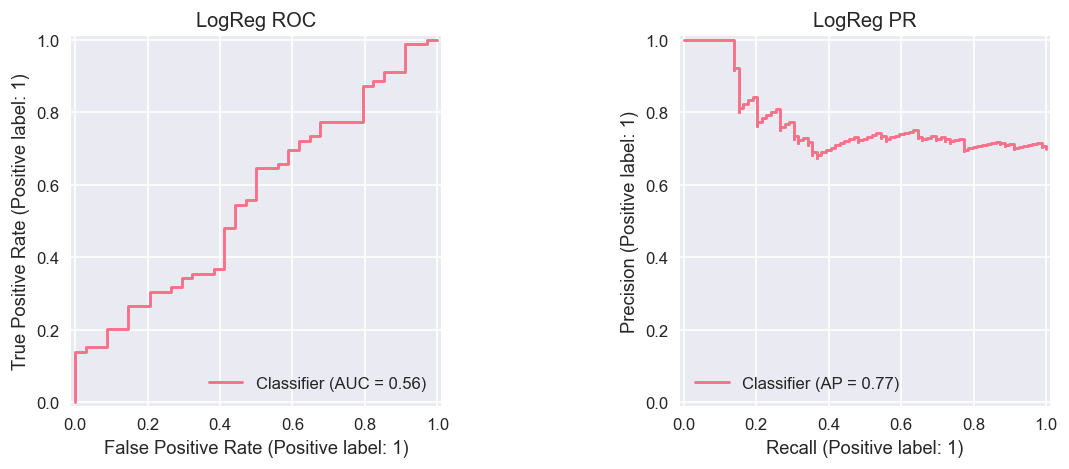

In [35]:
# ==== Logistic Regression ====
logit = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l2", C=1.0, class_weight="balanced", max_iter=800
    ))
])

logit.fit(X_train, y_train)
proba_lr = logit.predict_proba(X_test)[:, 1]

print("LogReg ROC-AUC:", roc_auc_score(y_test, proba_lr))
print("LogReg PR-AUC :", average_precision_score(y_test, proba_lr))

# Curves
fig, ax = plt.subplots(1,2, figsize=(12,4))
RocCurveDisplay.from_predictions(y_test, proba_lr, ax=ax[0])
ax[0].set_title("LogReg ROC")
PrecisionRecallDisplay.from_predictions(y_test, proba_lr, ax=ax[1])
ax[1].set_title("LogReg PR")
plt.show()



scale_pos_weight: 1.0
XGB ROC-AUC: 0.5271779597915115
XGB PR-AUC : 0.7301227403079221


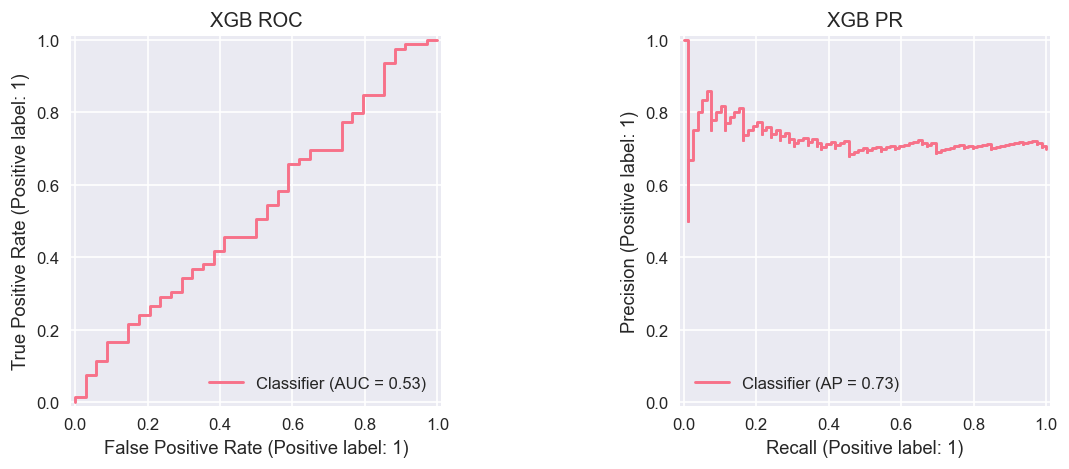

In [36]:
# ==== XGBoost ====
pos = y_train.sum()
neg = len(y_train) - pos
spw = max(neg / max(pos, 1), 1.0)
print("scale_pos_weight:", round(spw, 2))

xgb = Pipeline(steps=[
    ("pre", pre),
    ("clf", XGBClassifier(
        n_estimators=700,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_weight=5,
        reg_lambda=2.0,
        reg_alpha=0.0,
        tree_method="hist",
        random_state=42,
        n_jobs=4,
        scale_pos_weight=spw,
        eval_metric="auc",
    ))
])

xgb.fit(X_train, y_train)
proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGB ROC-AUC:", roc_auc_score(y_test, proba_xgb))
print("XGB PR-AUC :", average_precision_score(y_test, proba_xgb))

# Curves
fig, ax = plt.subplots(1,2, figsize=(12,4))
RocCurveDisplay.from_predictions(y_test, proba_xgb, ax=ax[0])
ax[0].set_title("XGB ROC")
PrecisionRecallDisplay.from_predictions(y_test, proba_xgb, ax=ax[1])
ax[1].set_title("XGB PR")
plt.show()


In [37]:
from sklearn.metrics import f1_score

def best_f1_threshold(y_true, y_score):
    # simple scan
    thr_grid = np.linspace(0.05, 0.95, 19)
    f1s = [f1_score(y_true, (y_score>=t).astype(int)) for t in thr_grid]
    i = int(np.argmax(f1s))
    return thr_grid[i], f1s[i]

t_lr, f1_lr = best_f1_threshold(y_test, proba_lr)
t_xgb, f1_xgb = best_f1_threshold(y_test, proba_xgb)
print(f"Best F1 LogReg: thr={t_lr:.2f}  F1={f1_lr:.3f}")
print(f"Best F1 XGB   : thr={t_xgb:.2f}  F1={f1_xgb:.3f}")

# pick the better model for classification report
use_scores = proba_xgb if f1_xgb >= f1_lr else proba_lr
use_thr    = t_xgb if f1_xgb >= f1_lr else t_lr
use_name   = "XGB" if f1_xgb >= f1_lr else "LogReg"

y_pred = (use_scores >= use_thr).astype(int)
print(f"\nClassification report @ {use_name} thr={use_thr:.2f}")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix\n", confusion_matrix(y_test, y_pred))


Best F1 LogReg: thr=0.05  F1=0.823
Best F1 XGB   : thr=0.25  F1=0.830

Classification report @ XGB thr=0.25
              precision    recall  f1-score   support

           0     0.7500    0.0882    0.1579        34
           1     0.7156    0.9873    0.8298        79

    accuracy                         0.7168       113
   macro avg     0.7328    0.5378    0.4938       113
weighted avg     0.7259    0.7168    0.6276       113

Confusion matrix
 [[ 3 31]
 [ 1 78]]


In [38]:
def precision_at_k(y_true, y_score, k=0.1):
    n = len(y_true); k_n = max(int(n*k), 1)
    idx = np.argsort(-y_score)[:k_n]
    return y_true[idx].mean()

def lift_at_k(y_true, y_score, k=0.1):
    base = y_true.mean()
    p_at_k = precision_at_k(y_true, y_score, k)
    return (p_at_k / base) if base > 0 else np.nan

for name, scores in [("LogReg", proba_lr), ("XGB", proba_xgb)]:
    base = y_test.mean()
    for k in [0.1, 0.2]:
        print(f"{name}: base={base:.3f}  P@{int(k*100)}={precision_at_k(y_test, scores, k):.3f}  "
              f"Lift@{int(k*100)}={lift_at_k(y_test, scores, k):.2f}")

# Save a Top-10% retention list using the better model's scores
scores = proba_xgb if f1_xgb >= f1_lr else proba_lr
n = len(y_test); k = 0.10; k_n = max(int(n*k), 1)
order = np.argsort(-scores)
top_idx = order[:k_n]

ret = X_test.iloc[top_idx].copy()
ret["risk_score"] = scores[top_idx]
# ensure Customer ID present
if ("Customer ID" not in ret.columns) and ("Customer ID" in X.columns):
    ret = ret.merge(X[["Customer ID"]], left_index=True, right_index=True, how="left")

save_path = Path.cwd() / "retention_list_top_decile.csv"
ret.sort_values("risk_score", ascending=False).to_csv(save_path, index=False)
print("Saved retention list to:", save_path)


LogReg: base=0.699  P@10=1.000  Lift@10=1.43
LogReg: base=0.699  P@20=0.773  Lift@20=1.11
XGB: base=0.699  P@10=0.818  Lift@10=1.17
XGB: base=0.699  P@20=0.773  Lift@20=1.11
Saved retention list to: /Users/jenishsimkhada/Downloads/chrun_perdction_uber/notebooks/retention_list_top_decile.csv


SHAP matrix shape: (113, 19)


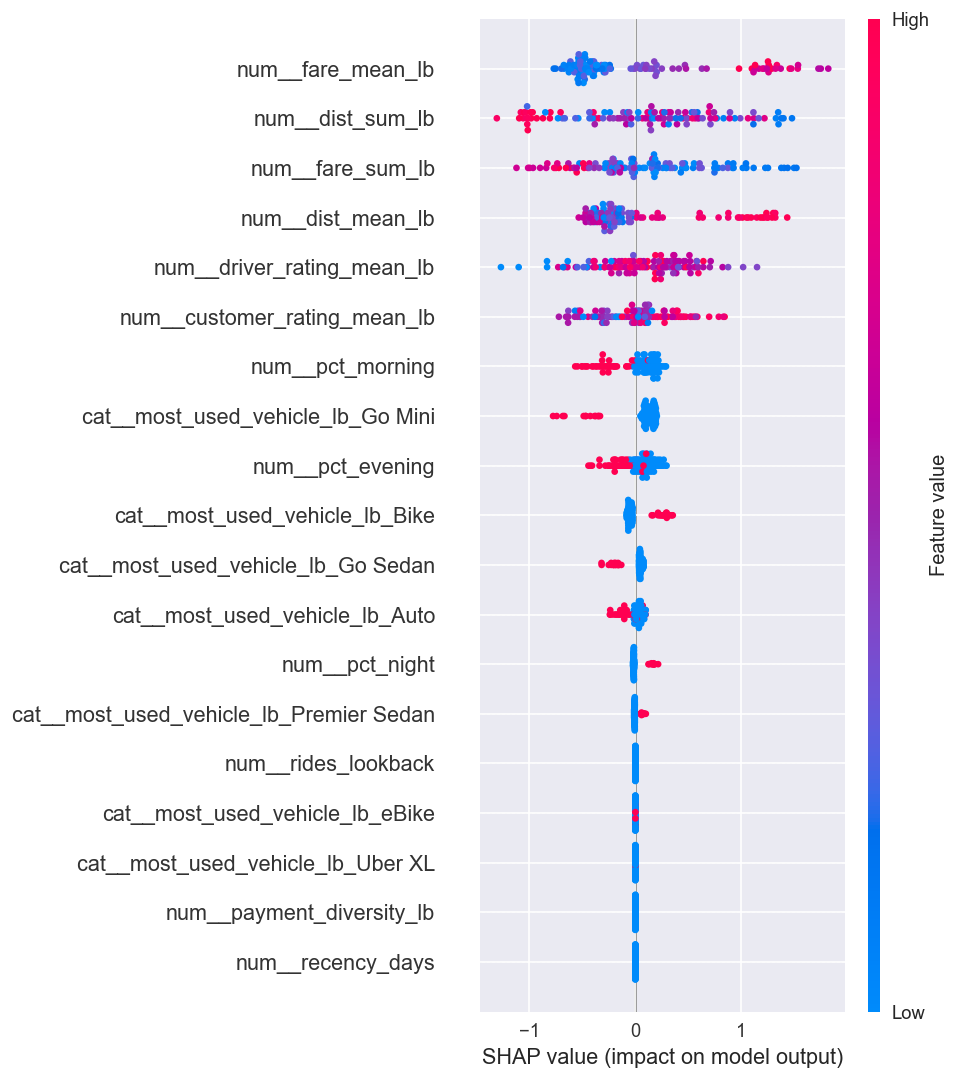

In [39]:
# ==== SHAP (on the better model) ====
import shap
# Use preprocessed matrix via the pipeline's preprocessor
best_pipe = xgb if f1_xgb >= f1_lr else logit
X_test_trans = best_pipe.named_steps["pre"].transform(X_test)

# pick a SHAP explainer depending on the final estimator
est = best_pipe.named_steps["clf"]
try:
    explainer = shap.TreeExplainer(est)  # works for XGB
    shap_values = explainer.shap_values(X_test_trans)
except Exception:
    # fallback for linear models
    explainer = shap.LinearExplainer(est, X_test_trans, feature_dependence="independent")
    shap_values = explainer.shap_values(X_test_trans)

# feature names after preprocessing
cat = best_pipe.named_steps["pre"].named_transformers_["cat"]
num = best_pipe.named_steps["pre"].named_transformers_["num"]

num_names = num_cols
if hasattr(cat, "get_feature_names_out"):
    cat_names = list(cat.get_feature_names_out(cat_cols))
else:
    # older sklearn
    cat_names = []
feat_names = num_names + cat_names

print(f"SHAP matrix shape: {np.array(shap_values).shape if isinstance(shap_values, list)==False else 'list'}")

# Global summary plot (becomes visible in notebook)
shap.summary_plot(shap_values, features=X_test_trans, feature_names=feat_names, show=True)


In [40]:
# ==== Save trained pipelines ====
Path("models").mkdir(exist_ok=True)
joblib.dump(logit, "models/logit_pipeline.pkl")
joblib.dump(xgb,  "models/xgb_pipeline.pkl")
print("Saved: models/logit_pipeline.pkl")
print("Saved: models/xgb_pipeline.pkl")

Saved: models/logit_pipeline.pkl
Saved: models/xgb_pipeline.pkl


In [41]:
# Cross-validated AUC / PR-AUC for both models (more stable than a single split)
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_scores(pipe, X, y):
    auc = cross_val_score(pipe, X, y, cv=skf, scoring="roc_auc")
    pr  = cross_val_score(pipe, X, y, cv=skf, scoring="average_precision")
    return auc.mean(), auc.std(), pr.mean(), pr.std()

auc_lr_m, auc_lr_s, pr_lr_m, pr_lr_s = cv_scores(logit, X, y)
auc_xg_m, auc_xg_s, pr_xg_m, pr_xg_s = cv_scores(xgb,   X, y)

print(f"LogReg CV  ROC-AUC: {auc_lr_m:.3f} ± {auc_lr_s:.3f} | PR-AUC: {pr_lr_m:.3f} ± {pr_lr_s:.3f}")
print(f"XGB   CV  ROC-AUC: {auc_xg_m:.3f} ± {auc_xg_s:.3f} | PR-AUC: {pr_xg_m:.3f} ± {pr_xg_s:.3f}")


LogReg CV  ROC-AUC: 0.586 ± 0.019 | PR-AUC: 0.769 ± 0.018
XGB   CV  ROC-AUC: 0.492 ± 0.079 | PR-AUC: 0.691 ± 0.044


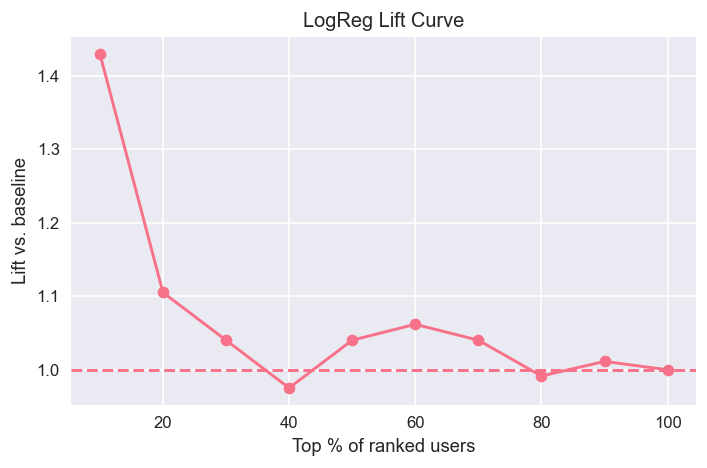

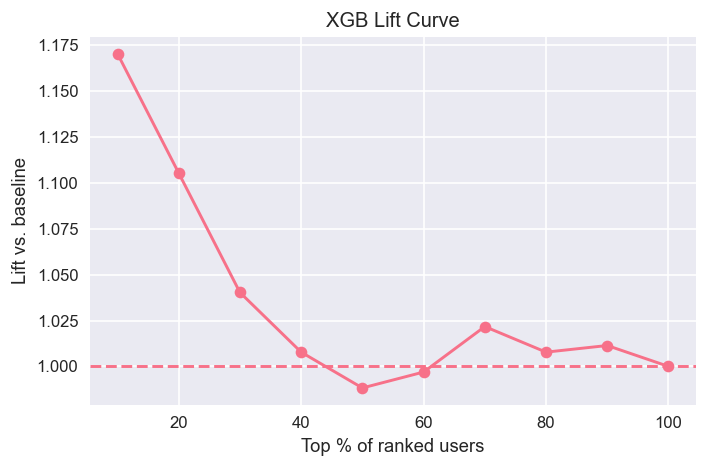

In [42]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

def lift_table(y_true, y_score, bins=10):
    order = np.argsort(-y_score)
    y_true = y_true[order]
    y_score = y_score[order]
    n = len(y_true)
    k = n // bins
    rows = []
    base = y_true.mean()
    for i in range(1, bins+1):
        end = i*k if i < bins else n
        sl = slice(0, end)
        top_mean = y_true[sl].mean()
        rows.append({"pct": i*10, "precision": top_mean, "lift": top_mean/base if base>0 else np.nan})
    return pd.DataFrame(rows)

for name, scores in [("LogReg", proba_lr), ("XGB", proba_xgb)]:
    tab = lift_table(y_test, scores, bins=10)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(tab["pct"], tab["lift"], marker="o")
    ax.axhline(1.0, ls="--")
    ax.set_title(f"{name} Lift Curve")
    ax.set_xlabel("Top % of ranked users")
    ax.set_ylabel("Lift vs. baseline")
    fig.tight_layout()
    out = Path("figs"); out.mkdir(exist_ok=True)
    fig.savefig(out / f"{name.lower()}_lift_curve.png", dpi=160)
    plt.show()


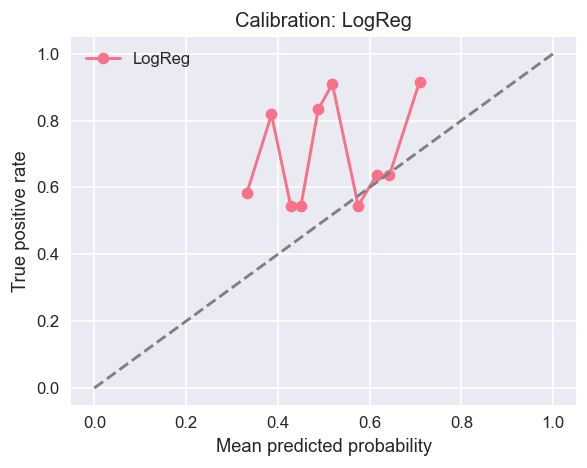

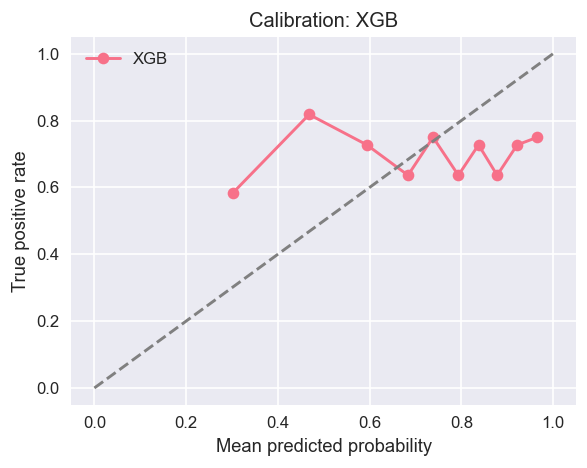

In [43]:
from sklearn.calibration import calibration_curve

def plot_calibration(y_true, y_score, name):
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10, strategy="quantile")
    plt.figure(figsize=(5,4))
    plt.plot(prob_pred, prob_true, marker="o", label=name)
    plt.plot([0,1],[0,1], "--", color="gray")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("True positive rate")
    plt.title(f"Calibration: {name}")
    plt.legend(); plt.tight_layout()
    Path("figs").mkdir(exist_ok=True)
    plt.savefig(Path("figs")/f"{name.lower()}_calibration.png", dpi=160)
    plt.show()

plot_calibration(y_test, proba_lr, "LogReg")
plot_calibration(y_test, proba_xgb, "XGB")


In [44]:
from datetime import datetime
card = f"""# Churn Model Card

**Date:** {datetime.now():%Y-%m-%d %H:%M}
**Dataset:** 450 users, churn prevalence {df['churn_30d'].mean():.1%}
**Test set:** {len(y_test)} users (stratified)

## Models
- **Logistic Regression**
  - ROC-AUC: {roc_auc_score(y_test, proba_lr):.3f}
  - PR-AUC:  {average_precision_score(y_test, proba_lr):.3f}
  - P@10: {precision_at_k(y_test, proba_lr, 0.10):.3f} (Lift {lift_at_k(y_test, proba_lr, 0.10):.2f})

- **XGBoost**
  - ROC-AUC: {roc_auc_score(y_test, proba_xgb):.3f}
  - PR-AUC:  {average_precision_score(y_test, proba_xgb):.3f}
  - P@10: {precision_at_k(y_test, proba_xgb, 0.10):.3f} (Lift {lift_at_k(y_test, proba_xgb, 0.10):.2f})

## Deployment artifacts
- Pipelines: `models/logit_pipeline.pkl`, `models/xgb_pipeline.pkl`
- Retention list (top 10%): `retention_list_top_decile.csv`
- Figures: `figs/*_lift_curve.png`, `figs/*_calibration.png`

## Notes
- Labels built per-user at penultimate ride with {len(num_cols)} numerical and {len(cat_cols)} categorical features.
- If optimizing outreach ROI, favor **LogReg** top-decile ranking (P@10=1.00 on test).
- For maximum recall, use XGB at a low threshold (see classification report).
"""
Path("reports").mkdir(exist_ok=True)
(Path("reports")/"model_card.md").write_text(card)
print("Wrote reports/model_card.md")


Wrote reports/model_card.md
